In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa.display import waveplot, specshow
from scipy.fftpack import dct, idct
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

import IPython.display
import seaborn

seaborn.set(style='ticks')

1. [Spectrograms in Python](https://timsainb.github.io/spectrograms-mfccs-and-inversion-in-python.html)

2. [Audio Tools in Python](https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe)

In [58]:
# filename = librosa.util.example_audio_file()
filename = 'handel.wav'
y,sr = librosa.load(filename)
y = y[:sr/2]
IPython.display.Audio(filename)

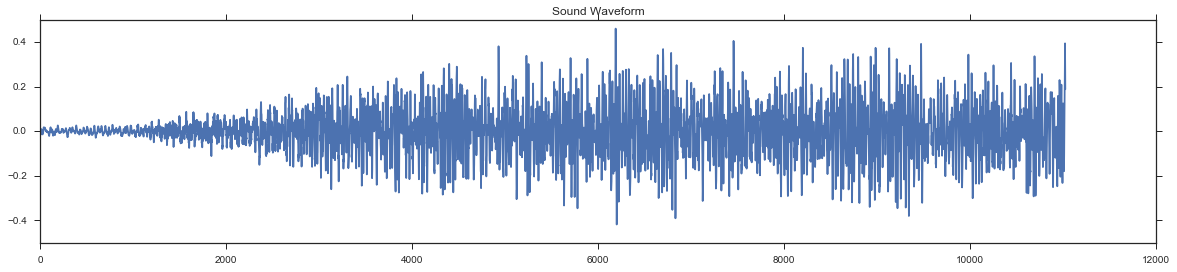

In [3]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(y)
plt.title('Sound Waveform')

In [4]:
def overlap(X, window_size, window_step):
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!") # assert an even number of windows

    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in xrange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out

In [5]:
def stdct(X, ndct=128, step=65, mean_normalize=True):
    # Compute STDCT for 1D real valued input X
    if mean_normalize:
        X -= X.mean()
    # if compute_onesided:
    #     cut = ndct // 2
    cut = None

    X = overlap(X, ndct, step)
    
    size = ndct
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = dct(X,norm='ortho')[:, :cut]
    return X

In [6]:
def log_stdct(d, log=True, thresh=5, ndct=128, step=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stdct(d))

    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold

    return specgram

## Log Translate & Transform
A common technique for handling negative values is to add a constant value to the data prior to applying the log transform. The transformation is therefore log(Y+a) where a is the constant. Some people like to choose a so that $min(Y+a)$ is a very small positive number (like 0.001). Others choose a so that $min(Y+a) = 1$. For the latter choice, you can show that $a = b – min(Y)$, where b is either a small number or is 1.
```
Y = {-3,1,2,.,5,10,100};    /* negative datum */
LY = log10(Y + 1 - min(Y)); /* translate, then transform */
```

$log(1+Y-min(Y))$

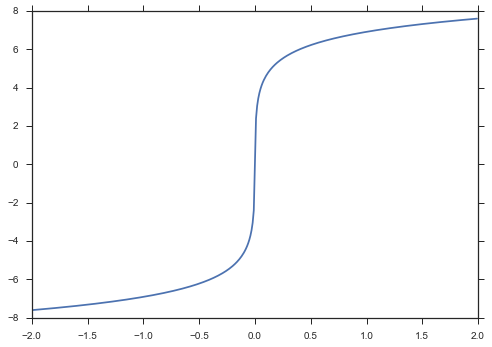

In [55]:
# Translate & Transform
x = np.arange(-2,2,0.01)
eps = 0.001
# y = np.piecewise(x,[x>eps, x<=eps], [lambda k: np.log(k+eps)-log(eps), lambda k: -1*(np.log(np.abs(k)+eps)-log(eps))])
y = np.sign(x)*(np.log(np.abs(x)+eps)-log(eps))

plt.plot(x,y)

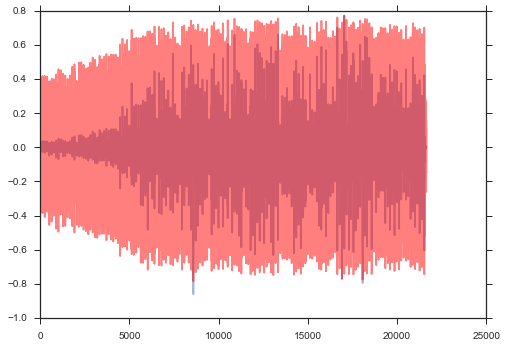

In [63]:
Y = stdct(y.astype('float64'))

S1 = Y.flatten()
eps = 0.001
S2 = np.sign(S1)*(np.log(np.abs(S1)+eps)-log(eps))
S2 = S2.flatten()
S2 /= S2.max()
S2 *= S1.max()

plt.plot(range(len(S1)),S1,range(len(S2)),S2,'r',alpha=0.5)

Y = np.sign(Y)*(np.log(np.abs(Y)+eps)-log(eps))

### Log-Modulus Transformation
A modification of the log transformation can help spread out the magnitude of the data while preserving the sign of data. It is called the log-modulus transformation ([John and Draper, 1980](https://www.jstor.org/stable/2986305)). The transformation takes the logarithm of the absolute value of the variable plus 1. If the original value was negative, "put back" the sign of the data by multiplying by –1. In symbols,

$L(x) = sign(x) * \log(|x| + 1)$


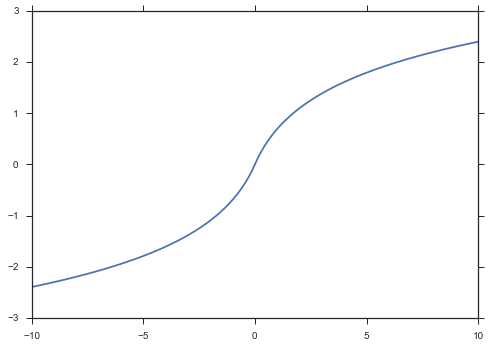

In [40]:
x = np.arange(-10,10,0.01)

# Log Modulus Transformation
y = np.sign(x)*np.log(np.abs(x)+1)
plt.plot(x,y)

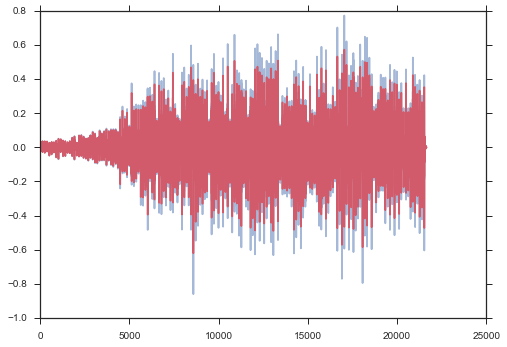

In [32]:
Y = stdct(y.astype('float64'))
Y.min(), Y.max()

S1 = Y.flatten()
S2 = np.sign(S1)*np.log(np.abs(S1)+1)
S2 = S2.flatten()


plt.plot(range(len(S1)),S1,range(len(S2)),S2,'r',alpha=0.5)

Y = np.sign(Y)*np.log(np.abs(Y)+1)

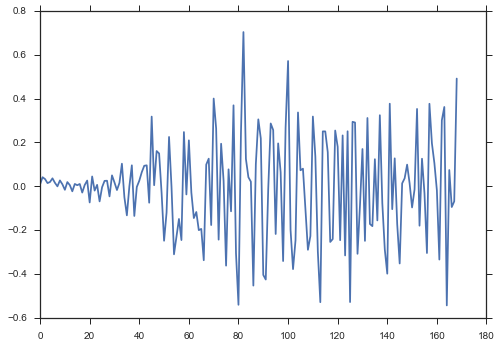

In [7]:
# Plot A single channel
Y = stdct(y.astype('float64'))
Y /= np.abs(Y).max()
# Y += 1
plt.plot(Y[:,12])

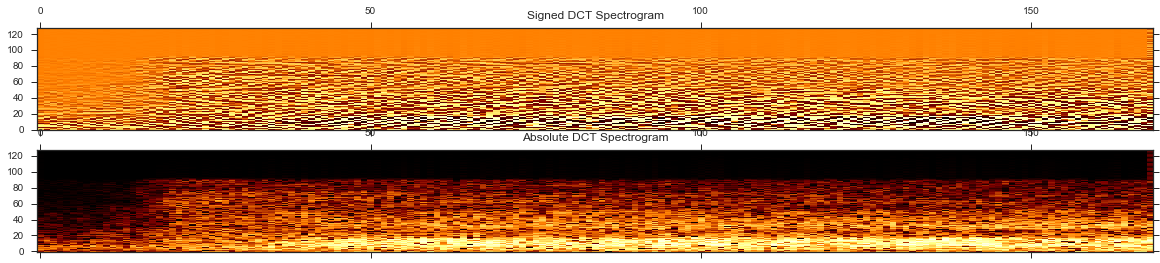

In [73]:
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,4))
cax = ax[0].matshow(np.transpose(Y), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
ax[0].set_title('Signed DCT Spectrogram')

cax = ax[1].matshow(np.transpose(np.abs(Y)), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
ax[1].set_title('Absolute DCT Spectrogram')

In [ ]:
Y = stdct(y.astype('float64'))

# Y = np.abs(Y)
Y /= np.abs(Y).max()
# Y += 1.01
# Y /= 2.01
# Y = np.log10(Y)
# thresh = 5
# Y[Y < -thresh] = -thresh

Y = np.sign(Y)*np.log(np.abs(Y)) # piecewise logarithm
plt.plot(Y.flatten())

In [ ]:
thresh = 15
Y[Y < -thresh] = -thresh
Y[Y > thresh]  =  thresh
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(Y), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
ax.get_xaxis().set_ticks([])
plt.title('DCT Spectrogram - Modified Log')

In [ ]:
YP = log_stdct(y.astype('float64'))

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(YP), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('DCT Spectrogram')

In [ ]:
ss = librosa.core.stft(y,n_fft=128,hop_length=64)
ss = librosa.core.amplitude_to_db(ss)

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,4))

cax = ax.matshow(np.abs(ss), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('STFT Spectrogram')

In [ ]:
Y = overlap(y,512,512/2)
Y.shape, y.shape

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram


## Inverse Spectrogram

In [ ]:
# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset


In [ ]:
wav_spectrogram = pretty_spectrogram(y.astype('float64'), fft_size = 128, 
                                   step_size = 64, log = True, thresh = 4)
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

In [ ]:
ss = stft(y,128,64)

In [ ]:
sr = np.real(ss)
si = np.imag(ss)
sm = np.absolute(ss)

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

D = np.transpose(si)
# D = np.transpose(np.log(np.abs(si)))
cax = ax.matshow(D, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
ax.get_xaxis().set_ticks([])
plt.title('STFT Spectrogram - Imag')

## Continuous Wavelet Analysis

In [ ]:
## Wavelet Transform
from scipy import signal
import matplotlib.pyplot as plt

k = 64
cwtmatr = signal.cwt(y, signal.ricker,np.arange(1,k))
plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.imshow(cwtmatr,extent=[-1,1,k,1],aspect='auto',cmap='PRGn')
# plt.colorbar()

# plt.imshow(cwtmatr, extent=[-1, 1, k, 1], cmap='PRGn', aspect='auto',
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.colorbar()

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.abs(cwtmatr), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)